# CNN Cancer Detection Kaggle Mini-Project

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from tensorflow.python.keras.saving.saved_model.serialized_attributes import metrics
import tensorflow as tf
import os
# import tifffile
import cv2

if os.path.exists(r'C:\Users\nikok\Documents'):
    raw_data_path = r'C:\Users\nikok\Documents\CNN Cancer Detection Kaggle Mini-Project'
else:
    raw_data_path = r'C:\Users\kuusnin\tempwork\temp\CNN Cancer Detection Kaggle Mini-Project'
train_labels = pd.read_csv(os.path.join(raw_data_path, 'train_labels.csv'))
train_labels.sort_values(by='id', inplace=True)


In [3]:
def read_pic(file, method='keras'):
    if method == 'keras':
        img = keras.utils.load_img(file)
        x = keras.utils.img_to_array(img)
        # x = np.expand_dims(x, axis=0)
    # if method == 'tifffile':
    #     img = tifffile.imrad(file)
    # elif method == 'cv2':
    #     img = cv2.imread(file)
    return img, x


## Brief description of the problem and data 
*Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.* 

The training set has 220k images and testing set has 57k images. The train/test split is 80/20. Number of images matches the number of labels in the csv file. 

Picture size is 96x96 (total number of pixels 9216) and three channels for RGB. The values in each channel take values between 0 and 255 ($2^8$, 8 bits).



In [4]:
train_files = os.listdir(os.path.join(raw_data_path, 'train'))
# train_files = os.listdir(os.path.join(raw_data_path, 'train_subset'))
test_files = os.listdir(os.path.join(raw_data_path, 'test'))
train_split = len(train_files)/(len(train_files)+len(test_files))

print('Number of training labels:', len(train_labels))
print('Number of training images:', len(train_files), '(' + str(round(train_split*100))+'%)')
print('Number of testing images:', len(test_files), '(' + str(round((1-train_split)*100))+'%)')


print('\nStructure of training labels dataframe:')
print(train_labels.head())
print('Five first training image names:')
print('\t'+'\n\t'.join(train_files[0:5]))

print()
img, X = read_pic(os.path.join(raw_data_path, 'train', train_files[0]))
img_size = X.shape
print('Image size:', X.shape[0:2])
print('Number of image channels', X.shape[-1])
print('Smallest and largest number in a picture:', np.min(X), np.max(X))

# for f in train_files:
#     read_pic(os.path.join(raw_data_path, 'train',f))

Number of training labels: 220025
Number of training images: 220025 (79%)
Number of testing images: 57458 (21%)

Structure of training labels dataframe:
                                              id  label
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5      1
16166   000020de2aa6193f4c160e398a8edea95b1da598      0
87832   00004aab08381d25d315384d646f5ce413ea24b1      0
69359   0000d563d5cfafc4e68acb7c9829258a298d9b6a      0
128953  0000da768d06b879e5754c43e2298ce48726f722      1
Five first training image names:
	00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
	000020de2aa6193f4c160e398a8edea95b1da598.tif
	00004aab08381d25d315384d646f5ce413ea24b1.tif
	0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif
	0000da768d06b879e5754c43e2298ce48726f722.tif

Image size: (96, 96)
Number of image channels 3
Smallest and largest number in a picture: 0.0 255.0


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
*Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?*


Any duplicated entries in labels: False
Do the ids in label csv match the image file names: True
Number of positive labels: 89117 (41%)
Number of negative labels: 130908 (59%)


PIL.TiffImagePlugin.TiffImageFile

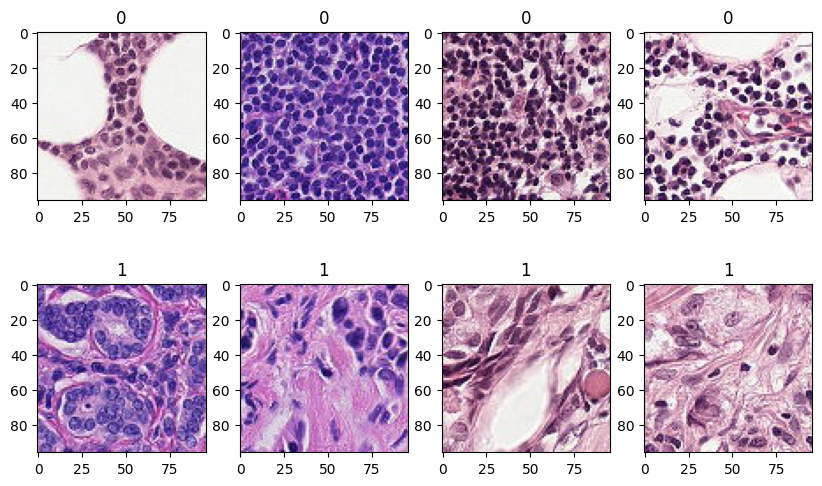

In [5]:
print('Any duplicated entries in labels:', np.any(train_labels.duplicated()))
print('Do the ids in label csv match the image file names:', np.all((train_files) == (train_labels.id+'.tif')))

pos = np.sum(train_labels.label == 1)
neg = np.sum(train_labels.label == 0)
print('Number of positive labels:', pos, '(' + str(round(pos/(neg+pos)*100))+'%)')
print('Number of negative labels:', neg, '(' + str(round(neg/(neg+pos)*100))+'%)')


plt.figure(figsize=(10, 6))
files = np.random.choice(train_labels.id[train_labels.label==0], 4, replace=False)
files = np.append(files, np.random.choice(train_labels.id[train_labels.label==1], 4, replace=False))
files = files + '.tif'
for i, file in enumerate(files):
    ax = plt.subplot(2, 4, i + 1)
    img, X = read_pic(os.path.join(raw_data_path, 'train', file))
    i_lbl = np.where(train_labels.id+'.tif' == file)[0]
    plt.title((train_labels.label.iloc[i_lbl].values)[0])
    plt.imshow(img)
type(img)


## Create a dataset
### First try

In [ ]:
# # https://keras.io/api/data_loading/image/
# directory = os.path.join(raw_data_path,'train')
# print(directory)
# train_ds, val_ds = keras.utils.image_dataset_from_directory(
#     directory,
#     labels=tuple(train_labels.label.values),
#     label_mode="int",
#     color_mode="rgb",
#     batch_size=32,
#     image_size=img_size[1:3],
#     shuffle=True,
#     seed=123,
#     validation_split=0.2,
#     subset="both",
#     interpolation="bilinear",
#     follow_links=False,
#     crop_to_aspect_ratio=False,
#     pad_to_aspect_ratio=False,
#     data_format=None,
#     verbose=True,
# )
# os.path.join(raw_data_path, train_files)

def load_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)  # Load TIFF image
    # image = cv2.resize(image, (256, 256))  # Resize image to a common size
    # image = image / 255.0  # Normalize pixel values
    return image

def process_path(file_path):
    image = tf.numpy_function(load_image, [file_path], tf.float32)
    return image

image_paths = [os.path.join(raw_data_path, 'train', item) for item in os.listdir(os.path.join(raw_data_path, 'train'))]
# image_paths = ([1, 2], [3, 4], [5, 6])

labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels.label.values)
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = tf.data.Dataset.zip((dataset, labels_dataset))

# Shuffle the dataset 
dataset = dataset.shuffle(len(image_paths)) 

# Calculate the size of the training and validation sets 
train_size = int(0.8 * len(image_paths)) 
val_size = len(image_paths) - train_size 

# Split the dataset 
train_ds = dataset.take(train_size) 
val_ds = dataset.skip(train_size) 

# Batch and prefetch 
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE) 
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# train_ds, val_ds = keras.utils.split_dataset(dataset, left_size=0.8, right_size=None, shuffle=False)
print(type(train_ds))
print(f"Training dataset size: {train_size}") 
print(f"Validation dataset size: {val_size}")

for image, label in val_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Training dataset size: 176020
Validation dataset size: 44005


### Alternative way
https://www.tensorflow.org/tutorials/load_data/images

In [48]:
import pathlib
import glob
import rasterio
# import tensorflow_io as tfio

data_dir = pathlib.Path(os.path.join(raw_data_path, 'train')).with_suffix('')
image_paths = [os.path.join(raw_data_path, 'train', item) for item in os.listdir(os.path.join(raw_data_path, 'train'))]
class_names = ['0','1']

image_count = len(image_paths)  #len(list(data_dir.glob('*/*.jpg')))
print(image_count)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*'), shuffle=False)
labels_ds = tf.data.Dataset.from_tensor_slices(train_labels.label.values)
list_ds = tf.data.Dataset.zip((list_ds, labels_ds))
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for (f, g) in list_ds.take(5):
    print(f.numpy())
    cv2.imread(str(f.numpy()), cv2.IMREAD_UNCHANGED)

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

def get_label(file_path):
  # Convert the path to a list of path components
  # parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  # return train_labels.label[train_labels.id+'.tif' == file_path]
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.bool(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  # img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  # return tf.image.resize(img, [img_size[1], img_size[2]])
  return cv2.imread(img.numpy().decode('utf-8'), cv2.IMREAD_UNCHANGED)  # Load TIFF image

def load_tif(file_path):
    file_path = file_path.numpy().decode('utf-8')
    with rasterio.open(file_path) as src:
        img = src.read()
    return np.transpose(img, (1, 2, 0))  # Transpose to (height, width, channels) if needed

def parse_tif(file_path, label):
    img = tf.py_function(load_tif, [file_path], tf.float32)
    # img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)  # Load TIFF image
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    label = label  # get_label(file_path)
    label = tf.convert_to_tensor(label, dtype=tf.int64)  # Adjust dtype based on your labels
    return img, label

def extract_string(tensor):
    return tf.py_function(lambda x: x.numpy().decode('utf-8'), [tensor], tf.string)

def process_path(file_path, label):
  # label = get_label(file_path)
  label = get_label(file_path)
  #
  # Load the raw data from the file as a string
  # img = tf.io.read_file(file_path)
  # img = read_pic(file_path)
  # img = tfio.experimental.image.decode_tiff(img)
  # file = tf.strings.format({}, file_path)
  img = cv2.imread(extract_string(file_path), cv2.IMREAD_UNCHANGED)  # Load TIFF image
  return img, label

def _fixup_shape(images, labels):
    images.set_shape((96,96,3))
    labels.set_shape([])
    return images, labels

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: tf.py_function(func=parse_tif, inp=[x, y], Tout=(tf.float32, tf.int64)), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: tf.py_function(func=parse_tif, inp=[x, y], Tout=(tf.float32, tf.int64)), num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(lambda x, y: parse_tif(x, y), num_parallel_calls=tf.data.AUTOTUNE) # No labels
# val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)  # Not working
train_ds = train_ds.map(_fixup_shape) #, which basically does the same thing (or am I wrong?).
val_ds = val_ds.map(_fixup_shape) #, which basically does the same thing (or am I wrong?).

for image, label in val_ds.take(5):
  print("Val Image shape: ", image.numpy().shape)
  print("Val Label: ", label.numpy())

image, label = next(val_ds.as_numpy_iterator())
print("Train Image shape:", image.shape)
print("Train Label:", label)

220025
b'C:\\Users\\nikok\\Documents\\CNN Cancer Detection Kaggle Mini-Project\\train\\799ee70253d21510202ac7383749cde480677cb3.tif'
b'C:\\Users\\nikok\\Documents\\CNN Cancer Detection Kaggle Mini-Project\\train\\bdf4546b9fa5416c11e39614a00cdacd23ea85cd.tif'
b'C:\\Users\\nikok\\Documents\\CNN Cancer Detection Kaggle Mini-Project\\train\\dda821e9256f79622ad2d493cf1c3631699e13a3.tif'
b'C:\\Users\\nikok\\Documents\\CNN Cancer Detection Kaggle Mini-Project\\train\\3a7758ba282ad101897b3af1bf9ae4b4eb883187.tif'
b'C:\\Users\\nikok\\Documents\\CNN Cancer Detection Kaggle Mini-Project\\train\\a9878ca4c1884024180f4a4f2a1e28ba44fffcc4.tif'
176020
44005
Val Image shape:  (96, 96, 3)
Val Label:  0
Val Image shape:  (96, 96, 3)
Val Label:  0
Val Image shape:  (96, 96, 3)
Val Label:  0
Val Image shape:  (96, 96, 3)
Val Label:  0
Val Image shape:  (96, 96, 3)
Val Label:  1
Train Image shape: (96, 96, 3)
Train Label: 0


In [ ]:
def get_img(path):
    path = bytes.decode(path) # called when use dataset since dataset is generator
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # Load TIFF image
    print(img.shape, type(img))
    return path

def wrap_get_img(path):  # turn tf.Tensor to tf.EagerTensor through the wrapper
    return tf.numpy_function(get_img, [path], [tf.string]) # [<tf.Tensor 'EagerPyFunc:0'


dataset = tf.data.Dataset.list_files("../prostate-cancer-grade-assessment/train_images/*.tiff") \
            .repeat()  \
            .shuffle(buffer_size=len(files)) \
            .map(wrap_get_img ) 

#### 3rd try
https://www.kaggle.com/code/grainier/histopathologic-cancer-detection-using-cnn

In [13]:
# keras.preprocessing.image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator


ImageDataGenerator

tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None
)

In [50]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  batch_size = 32
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

## Model Architecture
*Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.*

### Architecture
Activation
Filter sizes
Structure

### Hyperparameters
Padding
Filter size

In [52]:
# Adapted from images.ipynb
# 

def simple_model(input_shape, num_classes=2):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
    ])
    return model

# Adapted from 
# https://keras.io/examples/vision/image_classification_from_scratch/
def adv_model(input_shape, num_classes=2):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)



In [53]:
num_classes = 2
my_model = simple_model(input_shape=(96, 96, 3), num_classes=2)


In [55]:
num_classes = 2
my_model = adv_model(input_shape=(96, 96, 3), num_classes=2)

In [54]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
my_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
my_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 3925s 712ms/step - acc: 0.8462 - loss: 0.3458 - val_acc: 0.8765 - val_loss: 0.2579
Epoch 2/25
1313/5501 ━━━━━━━━━━━━━━━━━━━━ 33:27 479ms/step - acc: 0.9117 - loss: 0.2159

## Results and Analysis
*Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.*

*Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.*

## Conclusion
*Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?*

# Sources
https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

https://keras.io/examples/vision/image_classification_from_scratch/
